# DTU implementation of the NREL Cost and Scaling Model

In [1]:
import numpy as np

from py_wake.examples.data.iea37._iea37 import IEA37_WindTurbines, IEA37Site
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian


from topfarm.cost_models.economic_models.turbine_cost import economic_evaluation as ee_1


In [52]:
from topfarm.plotting import XYPlotComp, NoPlot

#set up plotting capability
try:
    import matplotlib.pyplot as plt
    plt.gcf()
    plot_comp = XYPlotComp()
    plot = True
except RuntimeError:
    plot_comp = NoPlot()
    plot = False


<Figure size 432x288 with 0 Axes>

### Define Site, WindTurbines and wake model.

In [12]:
n_wt=16
site=IEA37Site(n_wt)
windTurbines=IEA37_WindTurbines()
wake_model=IEA37SimpleBastankhahGaussian(site,windTurbines)

### Define vectors for turbine properties

In [15]:
Drotor_vector=[windTurbines.diameter()]*n_wt
power_rated_vector=[float(windTurbines.power(20)/1000)]*n_wt
hub_height_vector=[windTurbines.hub_height()]*n_wt

print(f'WT Hub Heigth {windTurbines.hub_height()}')
print(f'model {windTurbines.name()}')
print(f'power {windTurbines.power(ws_i=10)}')


WT Hub Heigth 110.0
model 3.35MW
power [3350000.]


In [31]:
site.initial_position[:,0]

array([    0.    ,   650.    ,   200.861 ,  -525.861 ,  -525.861 ,
         200.861 ,  1300.    ,  1051.7221,   401.7221,  -401.7221,
       -1051.7221, -1300.    , -1051.7221,  -401.7221,   401.7221,
        1051.7221])

In [39]:
wake_model(site.initial_position[:,0],site.initial_position[:,1])

<xarray.SimulationResult>
Dimensions:  (wd: 360, ws: 1, wt: 16)
Coordinates:
  * wt       (wt) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * wd       (wd) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * ws       (ws) float64 9.8
    x        (wt) float64 0.0 650.0 200.9 -525.9 ... -401.7 401.7 1.052e+03
    y        (wt) float64 0.0 0.0 618.2 382.1 ... -1.236e+03 -1.236e+03 -764.1
    h        (wt) float64 110.0 110.0 110.0 110.0 ... 110.0 110.0 110.0 110.0
    type     (wt) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    WS_eff   (wt, wd, ws) float64 9.776 9.761 9.738 9.704 ... 9.049 8.888 8.775
    TI_eff   (wt, wd, ws) float64 0.075 0.075 0.075 0.075 ... 0.075 0.075 0.075
    Power    (wt, wd, ws) float64 3.309e+06 3.284e+06 ... 2.005e+06 1.869e+06
    CT       (wt, wd, ws) float64 0.8889 0.8889 0.8889 ... 0.8889 0.8889 0.8889
    P        (wd) float64 0.001111 0.001111 0.001111 ... 0.001111 0.001111
    WD       (wd) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    WS       (ws) float64 9.8
    TI       float64 0.075
    Yaw      (wt, wd, ws) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [43]:
wake_model(site.initial_position[:,0],site.initial_position[:,1]).aep().sum(['wd']).values

array([[21.35819346],
       [20.24729439],
       [21.21374293],
       [22.31391355],
       [23.51838608],
       [22.1833577 ],
       [22.82582147],
       [23.12836812],
       [21.98886984],
       [23.85516698],
       [23.98971705],
       [24.62836115],
       [25.86402716],
       [26.69162624],
       [24.67556537],
       [24.72423372]])

## Set up functions for AEP and Cost calculation.

In [44]:
def aep_func(x,y, **kwargs):
    return wake_model(x,y).aep().sum(['wd','ws']).values*10**6

def irr_func(aep,**kwargs):
    my_irr=ee_1(Drotor_vector, power_rated_vector, hub_height_vector, aep).calculate_irr()
    print(my_irr)
    return my_irr

## Create an openmdao component for aep and irr to add to the problem.

In [47]:
from topfarm.cost_models.cost_model_wrappers import CostModelComponent, AEPCostModelComponent
# input keys
# cost function
# output key
# objective (False if is not the final obj.)
# output_val 

aep_comp= CostModelComponent(input_keys=['x','y'],
                            n_wt=n_wt,
                            cost_function=aep_func,
                            output_key='aep',
                            output_unit='GWh',
                            objective=False,
                            output_val=np.zeros(n_wt))

irr_comp= CostModelComponent(input_keys=['aep'],
                            n_wt=n_wt,
                            cost_function=irr_func,
                            output_key='irr',
                            output_unit='%',
                            objective=True,
                            income_model=True)


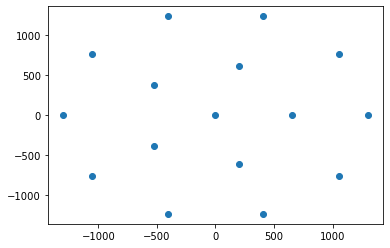

In [66]:
plt.scatter(site.initial_position[:,0],site.initial_position[:,1])

In [65]:
aep_func(site.initial_position[:,0],site.initial_position[:,1])

array([21358193.46288186, 20247294.3899654 , 21213742.92609528,
       22313913.55372591, 23518386.08027025, 22183357.7030569 ,
       22825821.46744289, 23128368.1205275 , 21988869.83522528,
       23855166.98082359, 23989717.05051072, 24628361.1536499 ,
       25864027.15813594, 26691626.24374531, 24675565.37301061,
       24724233.71528881])

* _Create a group for the AEP and IRR components that links their common input/output (aep)_
* _Define TopFarmProblem_

In [ ]:
from topfarm import TopFarmGroup, TopFarmProblem


irr_group=TopFarmGroup([aep_comp, irr_comp])

59.15317035889765
59.15317035889765
57.98745830604153
59.15317035889765
57.48032785084334
59.15317035889765
59.15317035889765
59.15317035889765
59.277623439909675
59.277623439909675
59.277623439909675
59.277623439909675
59.277623439909675
59.277623439909675
59.16879919670972
59.277623439909675
59.277623439909675
59.26757007708585
59.277623439909675
57.727130953755655
59.277623439909675
59.277623439909675
59.277623439909675
58.77507545724683
59.277623439909675
59.277623439909675
59.277623439909675
59.277623439909675
59.277623439909675
59.277623439909675
59.277623439909675
58.174917331136754
59.277623439909675
59.277623439909675
59.277623439909675
59.277623439909675
59.17740682605888
59.277623439909675
59.277623439909675
59.277623439909675
59.277623439909675
59.277623439909675
59.277623439909675
57.279040566825934
59.277623439909675
59.277623439909675
58.12450540124805
59.277623439909675
59.277623439909675
58.061391425417284
59.277623439909675
59.277623439909675
59.291242246396905
59.291

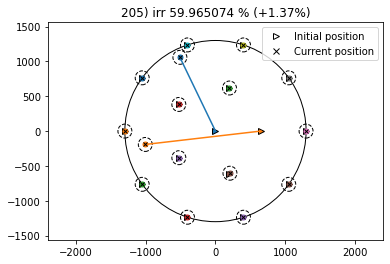

In [68]:
# Import Topfarm implementation of Random Search or Scipy drivers 
from topfarm.easy_drivers import EasyRandomSearchDriver, EasyScipyOptimizeDriver, EasySimpleGADriver

# Import Topfarm constraints for site boundary and spacing
from topfarm.drivers.random_search_driver import RandomizeTurbinePosition_Circle
from topfarm.constraint_components.boundary import CircleBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint

problem = TopFarmProblem(
        design_vars=dict(zip('xy', site.initial_position.T)),
        cost_comp=irr_group,
        driver=EasyRandomSearchDriver(randomize_func=RandomizeTurbinePosition_Circle(), max_iter=50),
        #driver=EasyScipyOptimizeDriver(optimizer='COBYLA', maxiter=200, tol=1e-6, disp=False),
        #driver=EasySimpleGADriver(max_gen=100, pop_size=5, Pm=None, Pc=.5, elitism=True, bits={}),
        constraints=[SpacingConstraint(200),
                     CircleBoundaryConstraint([0, 0], 1300.1)],
        plot_comp=plot_comp)

# assign data from optimizationn to a set of accessible variables and run the optimization
cost, state, recorder = problem.optimize()

59.15317035889765
58.69843233413623
59.15317035889765
59.15317035889765
57.3486498139727
59.15317035889765
59.15317035889765
59.15317035889765
59.64051790370459
59.64051790370459
59.64051790370459
59.21910130827859
59.64051790370459
59.64051790370459
59.64051790370459
59.64051790370459
59.64051790370459
59.64051790370459
59.64051790370459
59.64051790370459
59.64051790370459
59.64051790370459
59.64051790370459
59.64051790370459
58.90930885548813
59.64051790370459


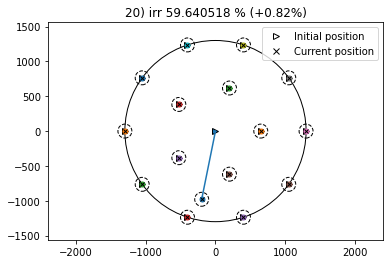

In [67]:
cost, state, recorder = problem.optimize()

59.965074359849254
59.965074359849254
59.965074359849254
59.965074359849254
59.965074359849254
59.965074359849254
59.965074359849254
59.757443645564834
59.965074359849254
59.335087248248854
59.965074359849254
59.965074359849254
59.965074359849254
59.922675677785996
59.965074359849254
59.965074359849254
59.5682257982874
59.965074359849254
59.965074359849254
59.24566167223024
59.965074359849254
59.965074359849254
59.965074359849254
59.41834342905516
59.965074359849254
59.88988527726744
59.965074359849254
59.965074359849254
59.965074359849254
59.95720788879923
59.965074359849254
59.965074359849254
59.965074359849254
59.82384563613445
59.965074359849254
59.965074359849254
59.965074359849254
60.05312414009949
60.05312414009949
60.05312414009949
59.400867462850314
60.05312414009949
60.05312414009949
60.05312414009949
59.57143780585614
60.05312414009949
59.327412459312654
60.05312414009949
60.05312414009949
60.05312414009949
60.05312414009949
60.05312414009949
58.43512646113673
60.05312414009

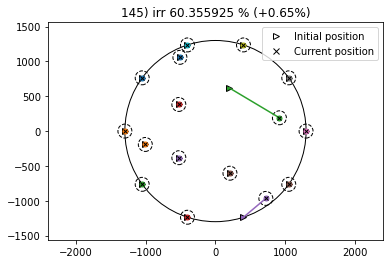

In [69]:
cost, state, recorder = problem.optimize()